In [95]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
import sys
sys.path.append("../BBTRE_physics_analysis/") 

In [147]:
import numpy as np
import xarray as xr

from xmitgcm import open_mdsdataset 
from xhistogram.xarray import histogram

import matplotlib.colors as colors

from osse import *
from canyon_utils import *
from sloped_MITgcm import *
from wmt import *

from blt_utils import *

In [98]:
data_dir = f"../..//MITgcm/experiments/BLT_realistic/run/"
budget_diags = ["tracer01Diag", "budgetDiag"]
ds = open_mdsdataset(data_dir,ignore_unknown_vars=True,prefix=budget_diags, delta_t=2.)
ds = ds.assign_coords({"hours": ds["time"].astype("float64")*1e-9/(3600.) - 120.})
add_attributes_from_datafile(ds, data_dir, datafiles=["data", "data.mypackage"])

t = (ds["time"].astype("float64")*1e-9)

ω = ds.attrs["omegaTide"]
ϕ = ds.attrs["phiTide"]
α = ds.attrs["tAlpha"]
θ = ds.attrs["slopeAngle"]
τ = ds.attrs["tau0Sponge"]
Γ = ds.attrs["lapseRate"]
N = np.sqrt(g*α*Γ)
f = ds.attrs["f0"]
U0 = ds.attrs["U0"]
Ur = U0*(ω**2/(ω**2-f**2-N**2*np.sin(θ)**2))

ds, grid = add_rotated_coords(ds, θ)
ds['dV'] = (ds.drF * ds.rA * ds.hFacC)

### Reconstructing the full temperature field

In [99]:
ds['THETA'] = ds['THETA'].where(ds['THETA'] != 0.)
ds['THETA_BG_C'] = Γ*ds['Zr']
ds['θ'] = ds['THETA'] + ds['THETA_BG_C']

In [102]:
add_gradients(ds, grid, 'θ');
ds = add_hab_coordinates(ds, grid, vert_coord='Zl', gridface='C');
ds['κ_hab'] = hab_interp(ds['KVDIFF'], vert_coord='Zl')
ds['κ_hab_av'] = ds['κ_hab'].mean(['XC', 'YC'], skipna=True).compute()

../BBTRE_physics_analysis/sloped_MITgcm.py:64: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  da_itp = xr.apply_ufunc(


In [100]:
btide = barotropic_tidal_response(ds["time"].astype("float64")*1e-9, U0, ω=ω, ϕ=ϕ, f=f, Γ=Γ, θ=θ, α=α)

In [131]:
ftide = np.cos(ϕ)*U0*ω*np.cos(ω*t)

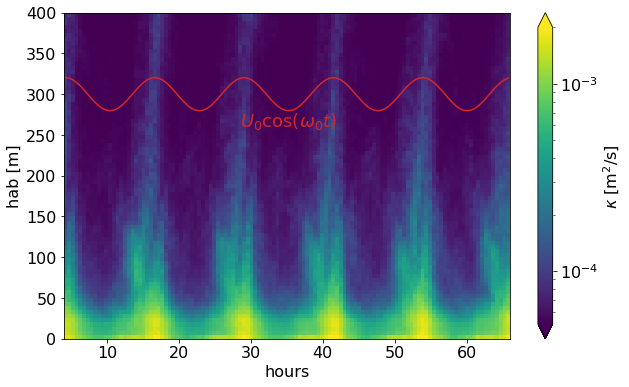

In [151]:
pc = ds['κ_hab_av'].plot(x="hours", norm=colors.LogNorm(vmin=5.2e-5, vmax=2e-3), extend="both")
pc.colorbar.set_label(r"$\kappa$ [m$^{2}$/s]")
plt.plot(ds['hours'], ftide*5e7+300, color="C3")
plt.annotate(text=r"$U_{0}\cos(\omega_{0} t)$", xy=(28.5, 260), color="C3", fontsize=18)
plt.ylim(0, 400)
plt.ylabel("hab [m]");

plt.savefig("../../figures/BLT/diffusivity_hab.png", dpi=150., bbox_inches="tight")